<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/GANs/Coursera/DCGANs/Concise%20Implementation/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Deep Convolutional GAN (DCGAN)`

## `Setup`

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## `Generator Model`

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

## `Discriminator Model`

In [5]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


## `Download Dataset`

In [6]:
batch_size = 128

In [7]:
# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [8]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## `Hyper Parameters`

In [9]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500

# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

In [10]:
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 
print("Final Generator Model : \n\n",gen)
print("\n\n\nFinal Disciminator Model : \n\n",disc)

Final Generator Model : 

 Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)



Final Disciminator Model : 

 Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1):

In [11]:
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [12]:
# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## `Training`

Step 500: Generator loss: 0.9452489312887199, discriminator loss: 0.493923523664474


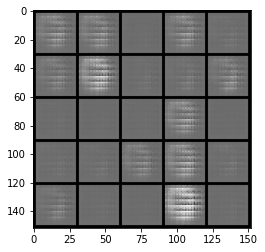

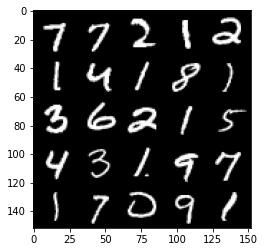

Step 1000: Generator loss: 1.712268770277501, discriminator loss: 0.3232264537364245


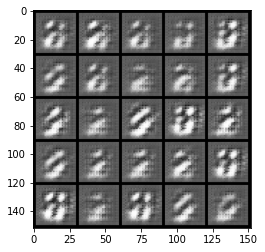

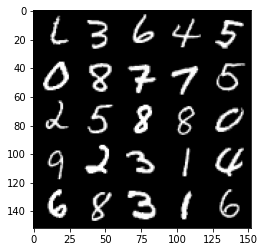

Step 1500: Generator loss: 1.3951245538592325, discriminator loss: 0.47762233036756535


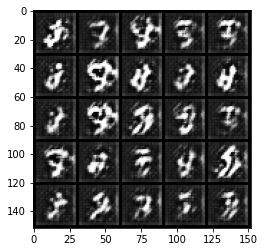

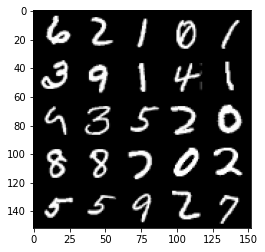

Step 2000: Generator loss: 1.0317875216603283, discriminator loss: 0.5591459492444991


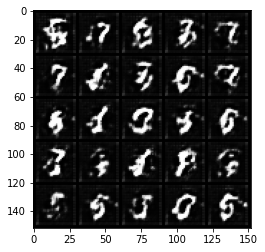

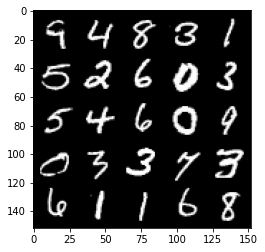

Step 2500: Generator loss: 0.9327683705389508, discriminator loss: 0.5841873688697815


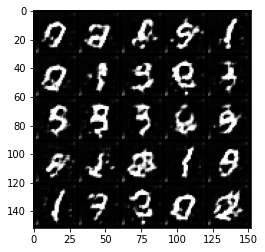

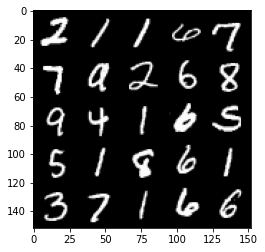

Step 3000: Generator loss: 0.8673861910104761, discriminator loss: 0.6115744174718865


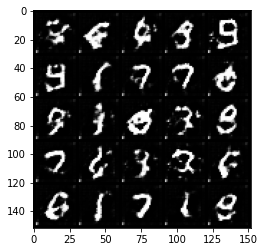

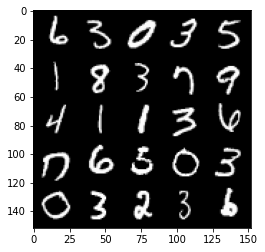

Step 3500: Generator loss: 0.8022137454152102, discriminator loss: 0.6424881669282911


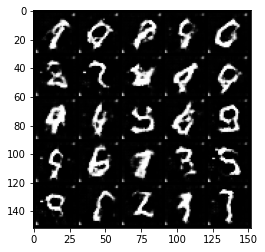

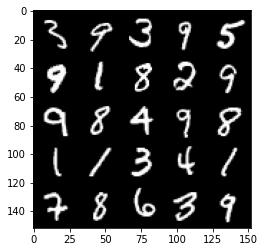

Step 4000: Generator loss: 0.7719575682878481, discriminator loss: 0.6575795240402219


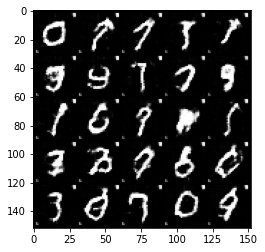

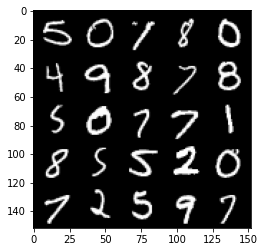

Step 4500: Generator loss: 0.770094535470009, discriminator loss: 0.6603487316370011


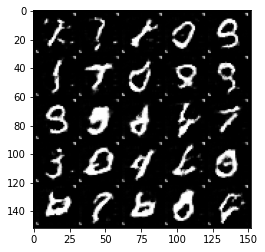

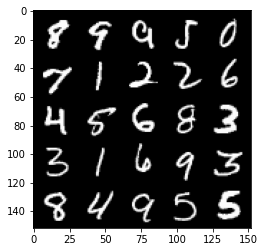

Step 5000: Generator loss: 0.7673277125954627, discriminator loss: 0.6635639619827263


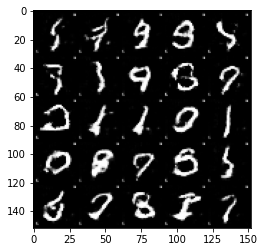

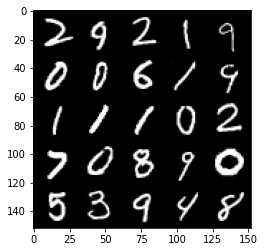

Step 5500: Generator loss: 0.7633899303674692, discriminator loss: 0.6689708204269414


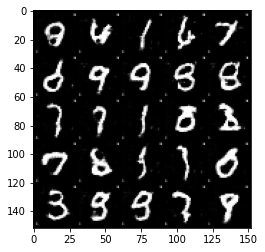

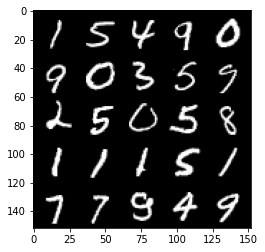

Step 6000: Generator loss: 0.7600517117977149, discriminator loss: 0.6721283823251721


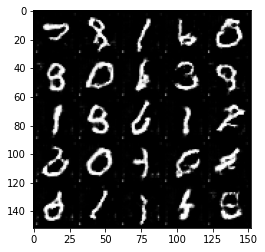

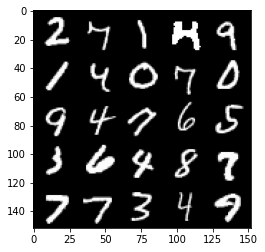

Step 6500: Generator loss: 0.7525891546010972, discriminator loss: 0.6766336007118225


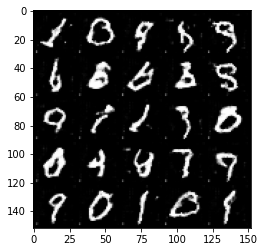

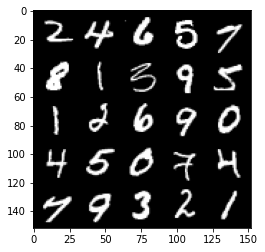

Step 7000: Generator loss: 0.7515884070992459, discriminator loss: 0.6792827596664427


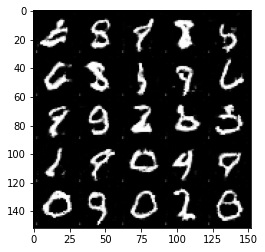

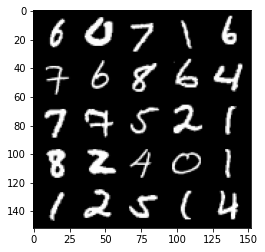

Step 7500: Generator loss: 0.7422568829059599, discriminator loss: 0.682393500566483


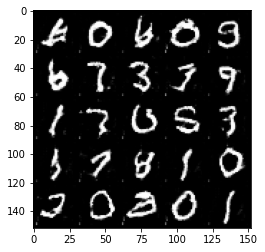

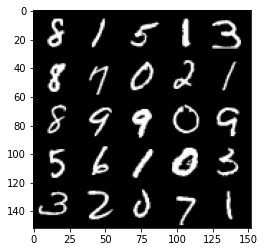

Step 8000: Generator loss: 0.7392206124067309, discriminator loss: 0.6832747704982752


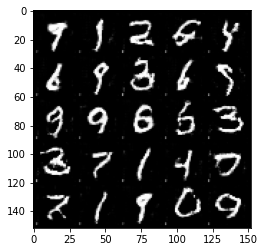

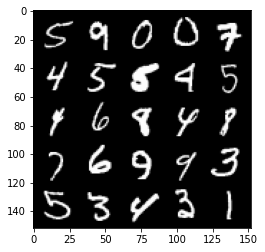

Step 8500: Generator loss: 0.7363226463794715, discriminator loss: 0.6841261130571367


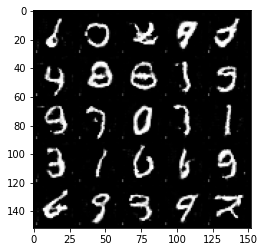

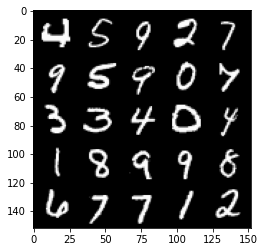

Step 9000: Generator loss: 0.7348869293928154, discriminator loss: 0.687948470115661


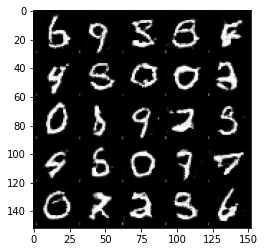

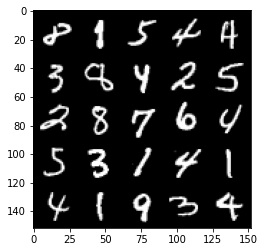

Step 9500: Generator loss: 0.7279078368544577, discriminator loss: 0.688633791208267


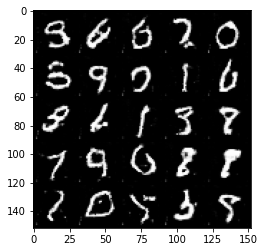

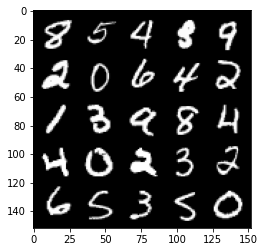

Step 10000: Generator loss: 0.7252018150687218, discriminator loss: 0.6902657425403598


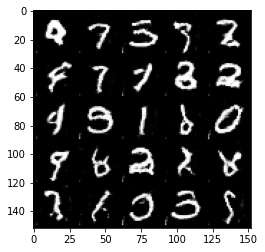

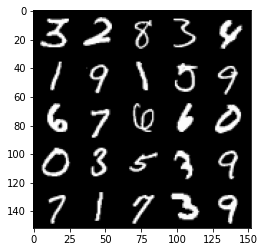

Step 10500: Generator loss: 0.7241442079544064, discriminator loss: 0.6905143100023268


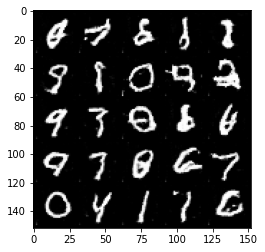

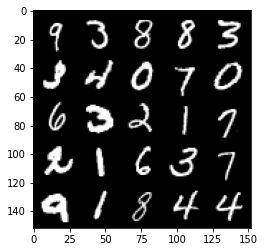

Step 11000: Generator loss: 0.7212800563573828, discriminator loss: 0.6930257475376138


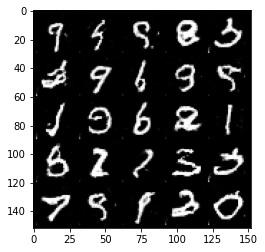

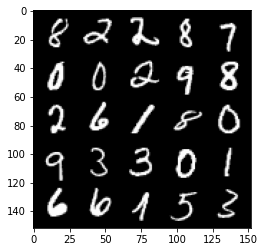

Step 11500: Generator loss: 0.718872404515743, discriminator loss: 0.6938667063713071


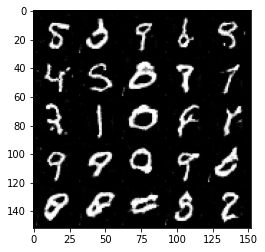

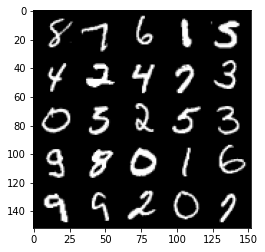

Step 12000: Generator loss: 0.7181400773525244, discriminator loss: 0.6943525396585467


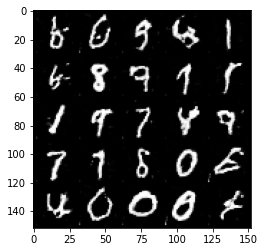

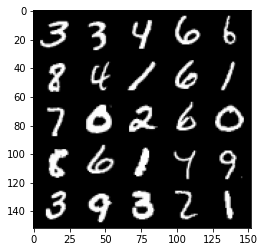

Step 12500: Generator loss: 0.7119270015954973, discriminator loss: 0.696123168230057


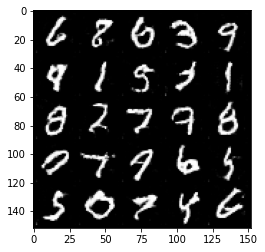

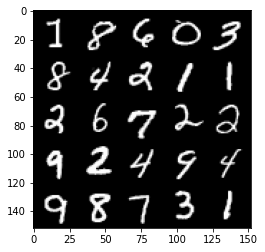

Step 13000: Generator loss: 0.712897631108761, discriminator loss: 0.6957903358936307


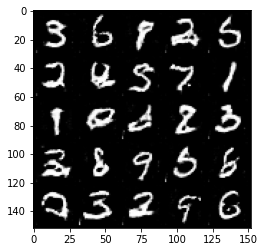

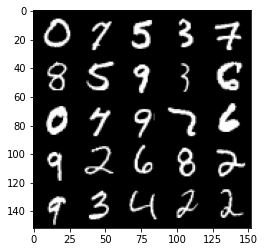

Step 13500: Generator loss: 0.7086838349699979, discriminator loss: 0.6966967031955721


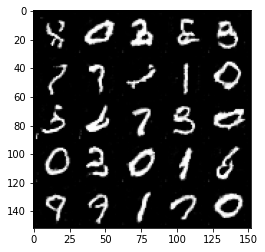

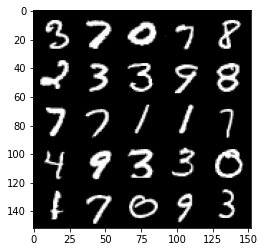

Step 14000: Generator loss: 0.7071776009201998, discriminator loss: 0.6965425939559932


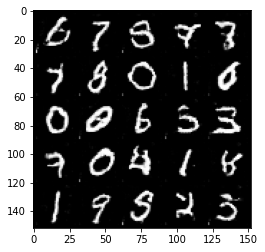

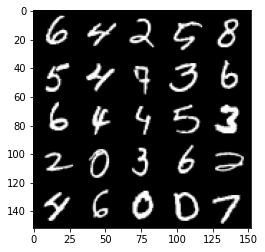

Step 14500: Generator loss: 0.7102690511941915, discriminator loss: 0.6969615607261651


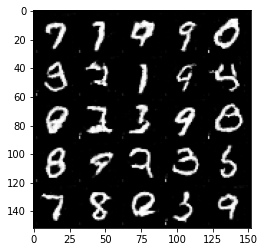

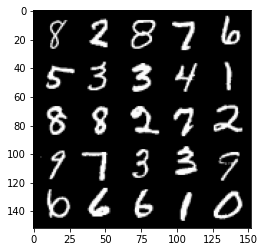

Step 15000: Generator loss: 0.7042258749008178, discriminator loss: 0.6962564347982408


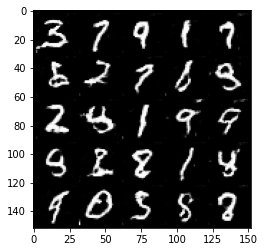

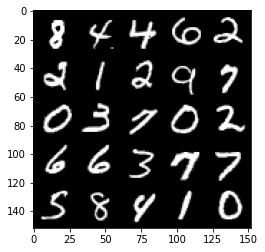

Step 15500: Generator loss: 0.7046774045228963, discriminator loss: 0.6969561256170271


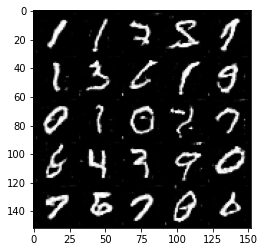

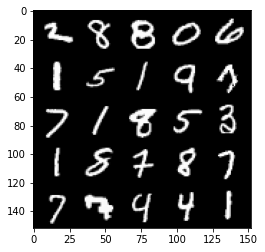

Step 16000: Generator loss: 0.7051940830945963, discriminator loss: 0.6973035229444499


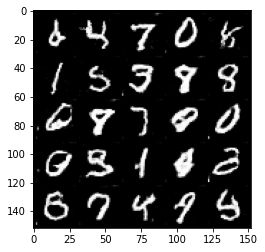

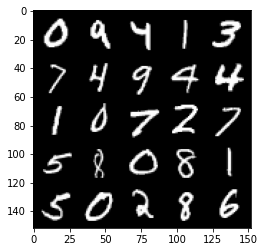

Step 16500: Generator loss: 0.7027900735139851, discriminator loss: 0.6963778629302975


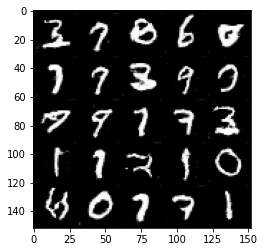

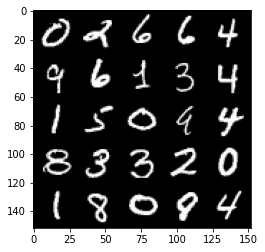

Step 17000: Generator loss: 0.7016688616275789, discriminator loss: 0.6969432158470149


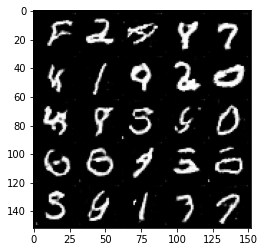

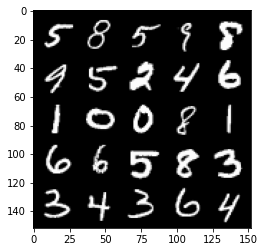

Step 17500: Generator loss: 0.7019119433760647, discriminator loss: 0.6968726967573161


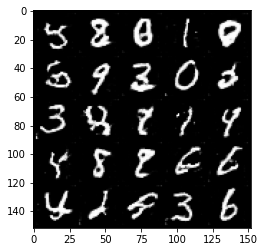

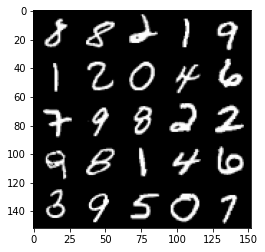

Step 18000: Generator loss: 0.7009993624687189, discriminator loss: 0.6968892290592197


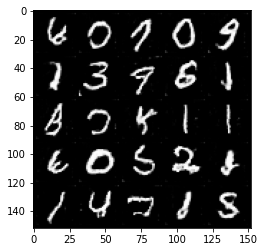

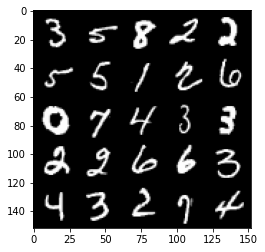

Step 18500: Generator loss: 0.7021268568038945, discriminator loss: 0.6968789455890662


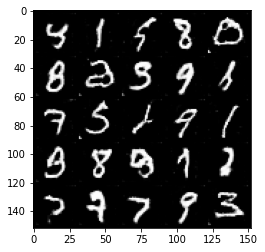

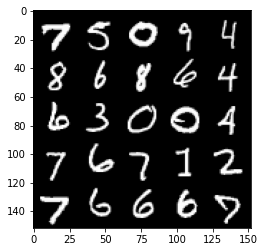

Step 19000: Generator loss: 0.6991815701723098, discriminator loss: 0.6968540196418765


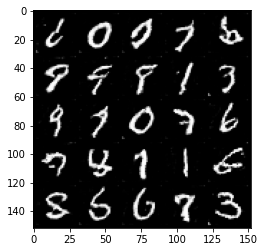

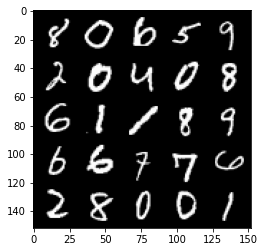

Step 19500: Generator loss: 0.6999498482942585, discriminator loss: 0.696625140786171


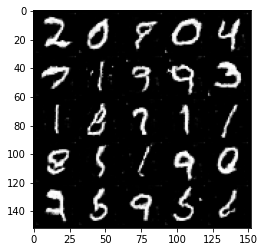

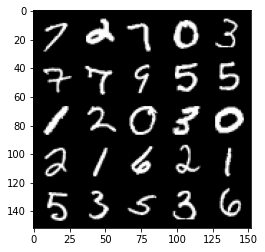

Step 20000: Generator loss: 0.6997897508144387, discriminator loss: 0.6960267999172207


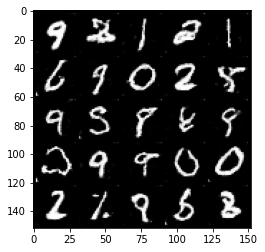

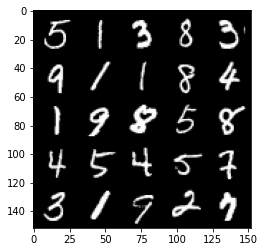

Step 20500: Generator loss: 0.696505503892899, discriminator loss: 0.6981999450922016


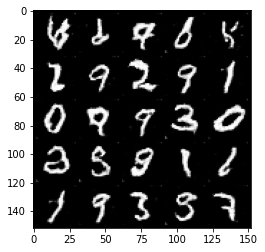

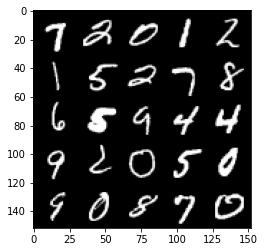

Step 21000: Generator loss: 0.6972435877323153, discriminator loss: 0.6966412801742559


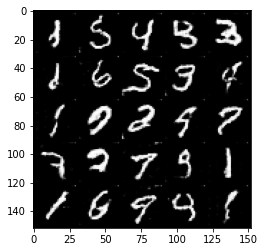

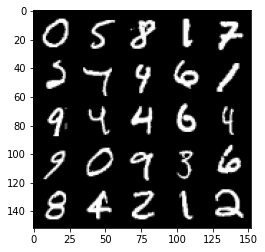

Step 21500: Generator loss: 0.69796220600605, discriminator loss: 0.6959646644592283


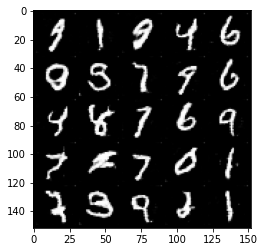

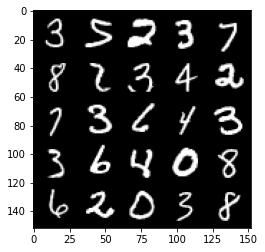

Step 22000: Generator loss: 0.6988337899446484, discriminator loss: 0.6958997769355774


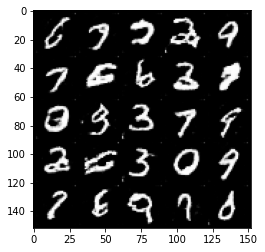

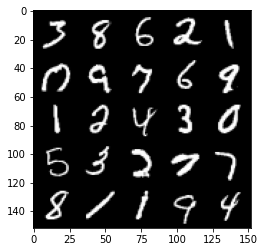

Step 22500: Generator loss: 0.6975912913084028, discriminator loss: 0.6960902355909354


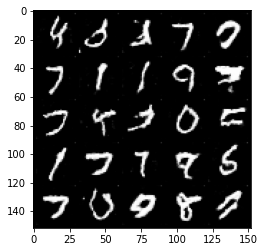

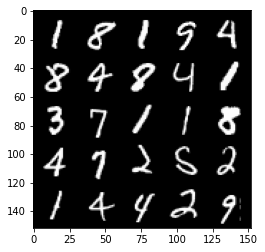

Step 23000: Generator loss: 0.695995910525322, discriminator loss: 0.6956459546089174


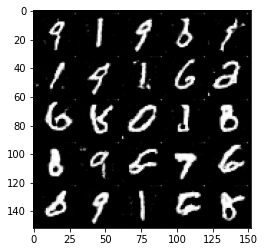

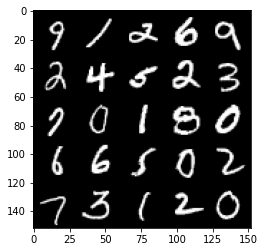

In [14]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
